In [9]:
import re
import matplotlib.pyplot as plt
from typing import Tuple, List
import numpy as np


def parse_meta_sr_log(filepath: str) -> Tuple[List[int], List[float], List[float]]:
    """
    Parse meta-SR log file to extract generation data.

    Args:
        filepath: Path to the log file

    Returns:
        Tuple of (generations, times_seconds, avg_r2_values)
        - generations: list of generation numbers (0 = baseline)
        - times_seconds: list of cumulative times in seconds
        - avg_r2_values: list of avg_r2 values per generation
    """
    generations = []
    times = []
    r2_values = []

    cumulative_time = 0.0

    with open(filepath, 'r') as f:
        content = f.read()

    # Parse baseline
    baseline_match = re.search(r'Baseline:.*avg_r2=([\d.]+)', content)
    if baseline_match:
        generations.append(0)
        times.append(0.0)
        r2_values.append(float(baseline_match.group(1)))

    # Parse each generation
    gen_pattern = r'Generation (\d+) Summary:.*?Best:.*?avg_r2=([\d.]+).*?\[TIMING\] Total generation time: ([\d.]+) seconds'

    for match in re.finditer(gen_pattern, content, re.DOTALL):
        gen_num = int(match.group(1))
        avg_r2 = float(match.group(2))
        gen_time = float(match.group(3))

        cumulative_time += gen_time

        generations.append(gen_num)
        times.append(cumulative_time)
        r2_values.append(avg_r2)

    return generations, times, r2_values

In [10]:
def plot_r2_over_time(
    filepath: str,
    validation_results_file: str = None,
    use_time: bool = False,
    figsize: Tuple[int, int] = (10, 6),
    max_generation: int = None
) -> None:
    """
    Plot average R^2 performance over generations or time.

    Args:
        filepath: Path to the log file
        validation_results_file: Path to validation_results.json (optional)
        use_time: If True, use cumulative time on x-axis; if False, use generation number
        figsize: Figure size tuple (width, height)
        max_generation: If specified, only plot up to this generation
    """
    import json

    generations, times, r2_values = parse_meta_sr_log(filepath)

    # Filter to max_generation if specified
    if max_generation is not None:
        mask = [g <= max_generation for g in generations]
        generations = [g for g, m in zip(generations, mask) if m]
        times = [t for t, m in zip(times, mask) if m]
        r2_values = [r for r, m in zip(r2_values, mask) if m]

    # Load validation results if provided
    val_generations = []
    val_r2_means = []
    val_r2_stds = []
    if validation_results_file:
        try:
            with open(validation_results_file, 'r') as f:
                val_results = json.load(f)
            for r in val_results:
                gen = r['generation']
                if max_generation is not None and gen > max_generation:
                    continue

                seeds = r.get('val_r2_seeds')
                val_r2 = r.get('val_r2')
                if seeds:
                    mean_val = float(np.mean(seeds))
                    std_val = float(np.std(seeds))
                elif val_r2 is not None:
                    mean_val = float(val_r2)
                    std_val = 0.0
                else:
                    continue

                val_generations.append(gen)
                val_r2_means.append(mean_val)
                val_r2_stds.append(std_val)
            print(f"Loaded {len(val_r2_means)} validation results")
        except Exception as e:
            print(f"Warning: Could not load validation results: {e}")

    fig, ax = plt.subplots(figsize=figsize)

    if use_time:
        x_data = [t / 60 for t in times]  # Convert to minutes
        x_label = 'Time (minutes)'
    else:
        x_data = generations
        x_label = 'Meta-evolution generation'
        ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))

    # Plot training R²
    ax.plot(x_data, r2_values, marker='o', linewidth=2, markersize=6,
            label='Train split $R^2$', color='#1f77b4')

    # Plot validation R² if available
    if val_generations and not use_time:
        ax.plot(val_generations, val_r2_means, marker='s', linewidth=2, markersize=6,
                label='Validation split $R^2$ (mean of 3 seeds)', color='#ff7f0e', linestyle='--')
        lower = [m - s for m, s in zip(val_r2_means, val_r2_stds)]
        upper = [m + s for m, s in zip(val_r2_means, val_r2_stds)]
        ax.fill_between(val_generations, lower, upper, color='#ff7f0e', alpha=0.2, linewidth=0)

    ax.set_xlabel(x_label, fontsize=12)
    ax.set_ylabel('Elite algorithm $R^2$', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_ylim(0.7, 1.0)

    if val_generations:
        ax.legend(loc='lower right', fontsize=10)

    plt.tight_layout()
    plt.savefig('meta_sr_r2.png', dpi=300)
    plt.show()


Loaded 8 validation results


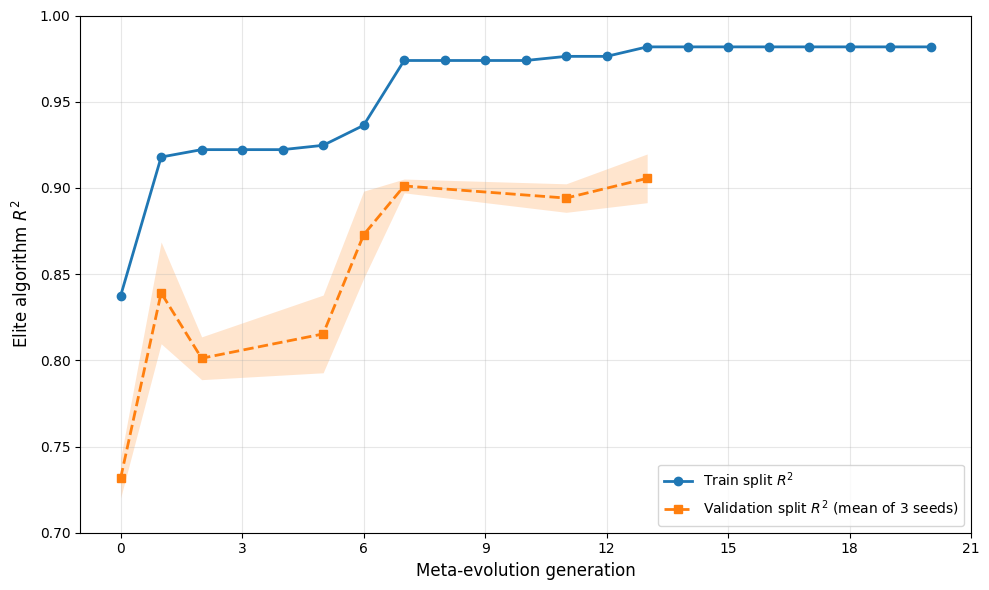

In [11]:
# Plot by generation number with validation results
plot_r2_over_time(
    'out/meta_228219.out',
    validation_results_file='results/run_20260115_214930/validation_eval/validation_results.json',
    use_time=False,
    max_generation=20
)

In [144]:
import json
from typing import Dict, Any, Optional
from dataclasses import dataclass


@dataclass
class EliteBundleInfo:
    """Information about the elite bundle at a generation."""
    generation: int
    evolved_operator: str
    n_perfect: int
    avg_r2: float
    score_vector: List[float]
    dataset_scores: Dict[str, float]  # dataset_name -> R^2
    operators: Dict[str, str]  # operator_type -> full code (when available)
    is_improvement: bool  # True if this generation improved R^2


def parse_log_file(log_file: str) -> Tuple[List[EliteBundleInfo], List[str]]:
    """
    Parse the full log file to extract elite bundle info per generation,
    including full operator code when NEW ELITE FOUND is printed.

    Args:
        log_file: Path to the full log file (e.g., 'out/meta_228219.out')

    Returns:
        Tuple of (elite_bundles, dataset_names)
    """
    with open(log_file, 'r') as f:
        content = f.read()

    # Extract dataset names
    datasets_match = re.search(r"Datasets: \[([^\]]+)\]", content)
    if datasets_match:
        datasets_str = datasets_match.group(1)
        dataset_names = [s.strip().strip("'\"") for s in datasets_str.split(',')]
    else:
        dataset_names = []

    elite_bundles = []

    # Parse baseline
    baseline_match = re.search(r'Baseline: n_perfect=(\d+), avg_r2=([\d.]+)', content)
    if baseline_match:
        n_perfect = int(baseline_match.group(1))
        avg_r2 = float(baseline_match.group(2))

        # Extract baseline per-dataset scores from Bundle 1 before "Baseline:"
        baseline_scores = {}
        bundle1_match = re.search(r'Bundle 1:\s*\n((?:\s+[\w_]+: R²=[\d.]+\n)+)', content[:content.find('Baseline:')])
        if bundle1_match:
            for line in bundle1_match.group(1).strip().split('\n'):
                ds_match = re.match(r'\s+([\w_]+): R²=([\d.]+)', line)
                if ds_match:
                    baseline_scores[ds_match.group(1)] = float(ds_match.group(2))

        score_vector = [baseline_scores.get(ds, 0.0) for ds in dataset_names]

        elite_bundles.append(EliteBundleInfo(
            generation=0,
            evolved_operator='baseline',
            n_perfect=n_perfect,
            avg_r2=avg_r2,
            score_vector=score_vector,
            dataset_scores=baseline_scores,
            operators={},  # Default operators, not printed
            is_improvement=False,
        ))

    # Parse each generation summary
    gen_pattern = r'Generation (\d+) Summary:\s*\n\s*Evolved: (\w+)\s*\n\s*Best: n_perfect=(\d+), avg_r2=([\d.]+)'

    for match in re.finditer(gen_pattern, content):
        gen_num = int(match.group(1))
        evolved_op = match.group(2)
        n_perfect = int(match.group(3))
        avg_r2 = float(match.group(4))

        elite_bundles.append(EliteBundleInfo(
            generation=gen_num,
            evolved_operator=evolved_op,
            n_perfect=n_perfect,
            avg_r2=avg_r2,
            score_vector=[],  # Will fill in from JSON if available
            dataset_scores={},
            operators={},  # Will fill in from NEW ELITE blocks
            is_improvement=False,
        ))

    # Now parse NEW ELITE FOUND blocks to get full operator code
    elite_pattern = r'\*\*\* NEW ELITE FOUND \(avg_r2=([\d.]+)\) \*\*\*\s*\n(.*?)(?=\n\nGeneration \d+ Summary:|\nGeneration \d+/\d+ -|\Z)'

    for match in re.finditer(elite_pattern, content, re.DOTALL):
        elite_r2 = float(match.group(1))
        elite_block = match.group(2)

        # Parse each operator from the block
        operators = {}
        for op_type in ['FITNESS', 'SELECTION', 'MUTATION', 'CROSSOVER']:
            op_pattern = rf'--- {op_type} ---\s*\n(.*?)(?=\n--- [A-Z]+ ---|\Z)'
            op_match = re.search(op_pattern, elite_block, re.DOTALL)
            if op_match:
                operators[op_type.lower()] = op_match.group(1).strip()

        # Find which bundle this corresponds to (by avg_r2)
        for bundle in elite_bundles:
            if abs(bundle.avg_r2 - elite_r2) < 1e-6 and not bundle.operators:
                bundle.operators = operators
                bundle.is_improvement = True
                break

    # Mark improvements based on R² progression
    prev_r2 = 0.0
    for bundle in elite_bundles:
        if bundle.avg_r2 > prev_r2 + 1e-6:
            bundle.is_improvement = True
        prev_r2 = bundle.avg_r2

    return elite_bundles, dataset_names


def load_dataset_scores_from_json(results_dir: str, elite_bundles: List[EliteBundleInfo], dataset_names: List[str]) -> None:
    """
    Load per-dataset scores from JSON files into elite_bundles (mutates in place).
    Reads from individual generation files in the generations/ directory.
    """
    import os

    gen_dir = os.path.join(results_dir, 'generations')
    if not os.path.exists(gen_dir):
        print(f"Warning: {gen_dir} not found, skipping per-dataset scores")
        return

    for bundle in elite_bundles:
        gen_file = os.path.join(gen_dir, f'gen_{bundle.generation:03d}.json')
        if not os.path.exists(gen_file):
            continue

        with open(gen_file, 'r') as f:
            gen_data = json.load(f)

        population = gen_data.get('population', [])
        if not population:
            continue

        # Find the best bundle by avg_r2
        best = max(population, key=lambda b: b.get('avg_r2', 0))
        score_vector = best.get('score_vector', [])

        bundle.score_vector = score_vector

        # Also populate dataset_scores dict
        if dataset_names and len(dataset_names) == len(score_vector):
            bundle.dataset_scores = {name: score for name, score in zip(dataset_names, score_vector)}

    loaded = sum(1 for b in elite_bundles if b.score_vector)
    print(f"Loaded per-dataset scores for {loaded}/{len(elite_bundles)} generations")

In [145]:
DEFAULT_OPERATORS = {
    'fitness': '''def fitness(loss_function, individual, X, y):
    loss = loss_function(individual, X, y)
    complexity_penalty = 0.01 * individual.size()
    return -loss - complexity_penalty''',

    'selection': '''def selection(population: List[Node], fitnesses: np.ndarray[float], n_crossover: int, n_mutation: int) -> Tuple[List[Tuple[Node, Node]], List[Node]]:
    """Select individuals via tournament selection"""
    def select_individual():
        tournament_size = 3
        tournament_indices = random.sample(range(len(population)), tournament_size)
        best_idx = max(tournament_indices, key=lambda i: fitnesses[i])
        return best_idx

    crossover_pairs = [(population[select_individual()], population[select_individual()]) for _ in range(n_crossover)]
    mutants = [population[select_individual()] for _ in range(n_mutation)]
    return crossover_pairs, mutants''',

    'mutation': '''def mutation(self, individual, n_vars):
    """Simple mutation: replace a random node"""
    new_individual = individual.copy()

    def get_all_nodes(node):
        if node is None:
            return []
        if node.left is None and node.right is None:
            return [node]
        nodes = [node]
        nodes.extend(get_all_nodes(node.left))
        nodes.extend(get_all_nodes(node.right))
        return nodes

    nodes = get_all_nodes(new_individual)
    target_node = random.choice(nodes)

    if random.random() < 0.5:
        replacement = self.create_terminal(n_vars)
        target_node.value = replacement.value
        target_node.left = None
        target_node.right = None
    else:
        replacement = self.create_random_tree(max_depth=2, n_vars=n_vars)
        target_node.value = replacement.value
        target_node.left = replacement.left
        target_node.right = replacement.right

    if new_individual.size() > self.max_size:
        return individual

    return new_individual''',

    'crossover': '''def crossover(self, parent1, parent2):
    """Simple crossover: swap random subtrees"""
    def get_all_nodes(node):
        if node is None:
            return []
        if node.left is None and node.right is None:
            return [node]
        nodes = [node]
        nodes.extend(get_all_nodes(node.left))
        nodes.extend(get_all_nodes(node.right))
        return nodes

    child = parent1.copy()
    child_nodes = get_all_nodes(child)
    parent2_nodes = get_all_nodes(parent2)

    if len(child_nodes) == 0 or len(parent2_nodes) == 0:
        return child

    target_node = random.choice(child_nodes)
    source_node = random.choice(parent2_nodes)

    target_node.value = source_node.value
    target_node.left = source_node.left.copy() if source_node.left else None
    target_node.right = source_node.right.copy() if source_node.right else None

    if child.size() > self.max_size:
        return parent1

    return child'''
}


def analyze_improvements(elite_bundles: List[EliteBundleInfo], output_file: str = None) -> None:
    """
    Analyze generations where R^2 improved and show the operator changes.

    Args:
        elite_bundles: List of EliteBundleInfo
        output_file: If specified, also write output to this file
    """
    from io import StringIO

    output = StringIO()

    def write(text):
        print(text)
        output.write(text + '\n')

    write("=" * 80)
    write("ANALYSIS OF R^2 IMPROVEMENTS ACROSS GENERATIONS")
    write("=" * 80)

    # Show baseline first
    baseline = elite_bundles[0] if elite_bundles else None
    if baseline and baseline.generation == 0:
        write(f"\n{'='*60}")
        write(f"Generation 0 (BASELINE): avg_r2={baseline.avg_r2:.4f}")
        write(f"n_perfect: {baseline.n_perfect}")
        write(f"{'='*60}")
        write("Default operators:")
        for op_type in ['fitness', 'selection', 'mutation', 'crossover']:
            write(f"\n{op_type.upper()}:")
            write("-" * 40)
            write(DEFAULT_OPERATORS[op_type])

    improvements = [b for b in elite_bundles if b.is_improvement and b.generation > 0]

    write(f"\n\nFound {len(improvements)} generations with R^2 improvement:\n")

    prev_r2 = elite_bundles[0].avg_r2 if elite_bundles else 0.0

    for bundle in elite_bundles:
        if bundle.is_improvement and bundle.generation > 0:
            delta = bundle.avg_r2 - prev_r2
            write(f"{'='*60}")
            write(f"Generation {bundle.generation}: R^2 {prev_r2:.4f} -> {bundle.avg_r2:.4f} (+{delta:.4f})")
            write(f"Evolved operator: {bundle.evolved_operator.upper()}")
            write(f"n_perfect: {bundle.n_perfect}")
            write(f"{'='*60}")

            # Show the evolved operator's full code
            evolved_op = bundle.evolved_operator
            if evolved_op in bundle.operators:
                write(f"\n{evolved_op.upper()} implementation:")
                write("-" * 40)
                write(bundle.operators[evolved_op])
                write("")
            else:
                write(f"\n(No code captured for {evolved_op})")

        if bundle.avg_r2 > prev_r2:
            prev_r2 = bundle.avg_r2

    # Save to file if specified
    if output_file:
        with open(output_file, 'w') as f:
            f.write(output.getvalue())
        print(f"\nSaved to {output_file}")


def show_final_elite(elite_bundles: List[EliteBundleInfo], output_file: str = None) -> None:
    """
    Show the final elite bundle's operators.

    Args:
        elite_bundles: List of EliteBundleInfo
        output_file: If specified, also write output to this file
    """
    from io import StringIO

    output = StringIO()

    def write(text):
        print(text)
        output.write(text + '\n')

    # Find the last bundle with operators
    final_with_ops = None
    for bundle in reversed(elite_bundles):
        if bundle.operators:
            final_with_ops = bundle
            break

    if not final_with_ops:
        write("No operator code found in log.")
        return

    write("")
    write("=" * 80)
    write(f"FINAL ELITE OPERATORS (from generation {final_with_ops.generation}, avg_r2={final_with_ops.avg_r2:.4f})")
    write("=" * 80)

    for op_type in ['fitness', 'selection', 'mutation', 'crossover']:
        if op_type in final_with_ops.operators:
            write(f"\n{'='*40}")
            write(f"{op_type.upper()}")
            write(f"{'='*40}")
            write(final_with_ops.operators[op_type])

    # Save to file if specified
    if output_file:
        with open(output_file, 'w') as f:
            f.write(output.getvalue())
        print(f"\nSaved to {output_file}")


def plot_per_dataset_r2(elite_bundles: List[EliteBundleInfo], dataset_names: List[str],
                        figsize=(14, 8), log_scale: bool = False) -> None:
    """
    Plot per-dataset R^2 scores over generations as a heatmap.
    Datasets are sorted by average R^2 (worst at top, best at bottom).

    Args:
        elite_bundles: List of EliteBundleInfo
        dataset_names: List of dataset names
        figsize: Figure size
        log_scale: If True, plot log10(1 - R^2) to emphasize differences near 1.0
    """
    import numpy as np
    from matplotlib.colors import LogNorm, Normalize

    # Filter to bundles with score vectors
    bundles_with_scores = [b for b in elite_bundles if b.score_vector]

    if not bundles_with_scores:
        print("No per-dataset scores available")
        return

    generations = [b.generation for b in bundles_with_scores]

    # Build matrix: rows = datasets, cols = generations
    matrix = []
    for i, ds in enumerate(dataset_names):
        row = [b.score_vector[i] if i < len(b.score_vector) else 0 for b in bundles_with_scores]
        matrix.append(row)
    matrix = np.array(matrix)

    # Sort datasets by average R^2 (ascending, so worst at top, best at bottom)
    avg_r2_per_dataset = matrix.mean(axis=1)
    sorted_indices = np.argsort(avg_r2_per_dataset)  # ascending order
    matrix = matrix[sorted_indices]
    sorted_dataset_names = [dataset_names[i] for i in sorted_indices]

    fig, ax = plt.subplots(figsize=figsize)

    if log_scale:
        # Plot 1 - R^2 (error) on log scale - lower is better
        # Clip to avoid log(0)
        error_matrix = np.clip(1 - matrix, 1e-6, 1.0)
        im = ax.imshow(error_matrix, aspect='auto', cmap='RdYlGn_r',
                       norm=LogNorm(vmin=1e-4, vmax=1.0))
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('$1 - R^2$ (error, log scale)', fontsize=10)
    else:
        im = ax.imshow(matrix, aspect='auto', cmap='RdYlGn', vmin=0, vmax=1)
        cbar = plt.colorbar(im, ax=ax)
        cbar.set_label('$R^2$', fontsize=10)

    ax.set_xticks(range(len(generations)))
    ax.set_xticklabels(generations)
    ax.set_yticks(range(len(sorted_dataset_names)))
    ax.set_yticklabels([ds.replace('feynman_', '') for ds in sorted_dataset_names], fontsize=8)

    ax.set_xlabel('Generation')
    ax.set_ylabel('Dataset (sorted by avg $R^2$: worst at top, best at bottom)')
    title = 'Per-Dataset Error ($1 - R^2$, log scale)' if log_scale else 'Per-Dataset $R^2$ Scores'
    ax.set_title(title)

    plt.tight_layout()
    plt.show()

In [146]:
# Parse the log file
log_file = 'out/meta_228219.out'
results_dir = 'results/run_20260115_214930'  # Corresponding results directory

# Filter to only include generations up to this value (set to None for all)
max_generation = 20

elite_bundles, dataset_names = parse_log_file(log_file)

# Load per-dataset scores from individual generation JSON files
load_dataset_scores_from_json(results_dir, elite_bundles, dataset_names)

# Filter to max_generation if specified
if max_generation is not None:
    elite_bundles = [b for b in elite_bundles if b.generation <= max_generation]

print(f"Parsed {len(elite_bundles)} generations (up to gen {max_generation if max_generation else 'all'})")
print(f"Datasets: {len(dataset_names)}")
print(f"Improvements found: {sum(1 for b in elite_bundles if b.is_improvement and b.generation > 0)}")

Loaded per-dataset scores for 26/27 generations
Parsed 21 generations (up to gen 20)
Datasets: 20
Improvements found: 7


In [147]:
# Summary table of elite bundles per generation
print(f"{'Gen':<5} {'Evolved':<12} {'n_perfect':<10} {'avg_r2':<10} {'Delta':<10}")
print("-" * 50)

prev_r2 = None
for bundle in elite_bundles:
    delta = f"+{bundle.avg_r2 - prev_r2:.4f}" if prev_r2 is not None and bundle.avg_r2 > prev_r2 else ""
    print(f"{bundle.generation:<5} {bundle.evolved_operator:<12} {bundle.n_perfect:<10} {bundle.avg_r2:<10.4f} {delta}")
    prev_r2 = bundle.avg_r2

Gen   Evolved      n_perfect  avg_r2     Delta     
--------------------------------------------------
0     baseline     2          0.8374     
1     fitness      2          0.9179     +0.0805
2     selection    3          0.9222     +0.0043
3     mutation     3          0.9222     
4     crossover    3          0.9222     
5     fitness      1          0.9247     +0.0025
6     selection    6          0.9363     +0.0116
7     mutation     5          0.9739     +0.0376
8     crossover    5          0.9739     
9     fitness      5          0.9739     
10    selection    5          0.9739     
11    mutation     4          0.9763     +0.0024
12    crossover    4          0.9763     
13    fitness      6          0.9818     +0.0055
14    selection    6          0.9818     
15    mutation     6          0.9818     
16    crossover    6          0.9818     
17    fitness      6          0.9818     
18    selection    6          0.9818     
19    mutation     6          0.9818     
20    cr

In [148]:
# Analyze improvements - shows full operator code for each improvement
analyze_improvements(elite_bundles, output_file='improvements_analysis.txt')

ANALYSIS OF R^2 IMPROVEMENTS ACROSS GENERATIONS

Generation 0 (BASELINE): avg_r2=0.8374
n_perfect: 2
Default operators:

FITNESS:
----------------------------------------
def fitness(loss_function, individual, X, y):
    loss = loss_function(individual, X, y)
    complexity_penalty = 0.01 * individual.size()
    return -loss - complexity_penalty

SELECTION:
----------------------------------------
def selection(population: List[Node], fitnesses: np.ndarray[float], n_crossover: int, n_mutation: int) -> Tuple[List[Tuple[Node, Node]], List[Node]]:
    """Select individuals via tournament selection"""
    def select_individual():
        tournament_size = 3
        tournament_indices = random.sample(range(len(population)), tournament_size)
        best_idx = max(tournament_indices, key=lambda i: fitnesses[i])
        return best_idx

    crossover_pairs = [(population[select_individual()], population[select_individual()]) for _ in range(n_crossover)]
    mutants = [population[select_indivi

In [149]:
# Show final elite operators
show_final_elite(elite_bundles, output_file='final_elite_operators.txt')


FINAL ELITE OPERATORS (from generation 13, avg_r2=0.9818)

FITNESS
def fitness(loss_function, individual, X, y):
    """
    Compute fitness score for an individual.

    Args:
        loss_function: A callable loss_function(individual, X, y) -> float (lower is better).
                       Handles numerical stability (overflow, invalid values).
        individual: A Node representing the expression tree
        X: numpy array of input features (n_samples, n_features)
        y: numpy array of target values (n_samples,)

    Returns:
        float: fitness score (higher is better)

    Available Node methods:
        individual.size() -> int: number of nodes in expression tree
        individual.height() -> int: height of expression tree
        individual.evaluate(X) -> np.ndarray: evaluate expression on input X
    """
    eps = 1e-8
    try:
        y_pred = np.asarray(individual.evaluate(X), dtype=float).ravel()
    except Exception:
        return -1e9
    finite = np.isfinite(

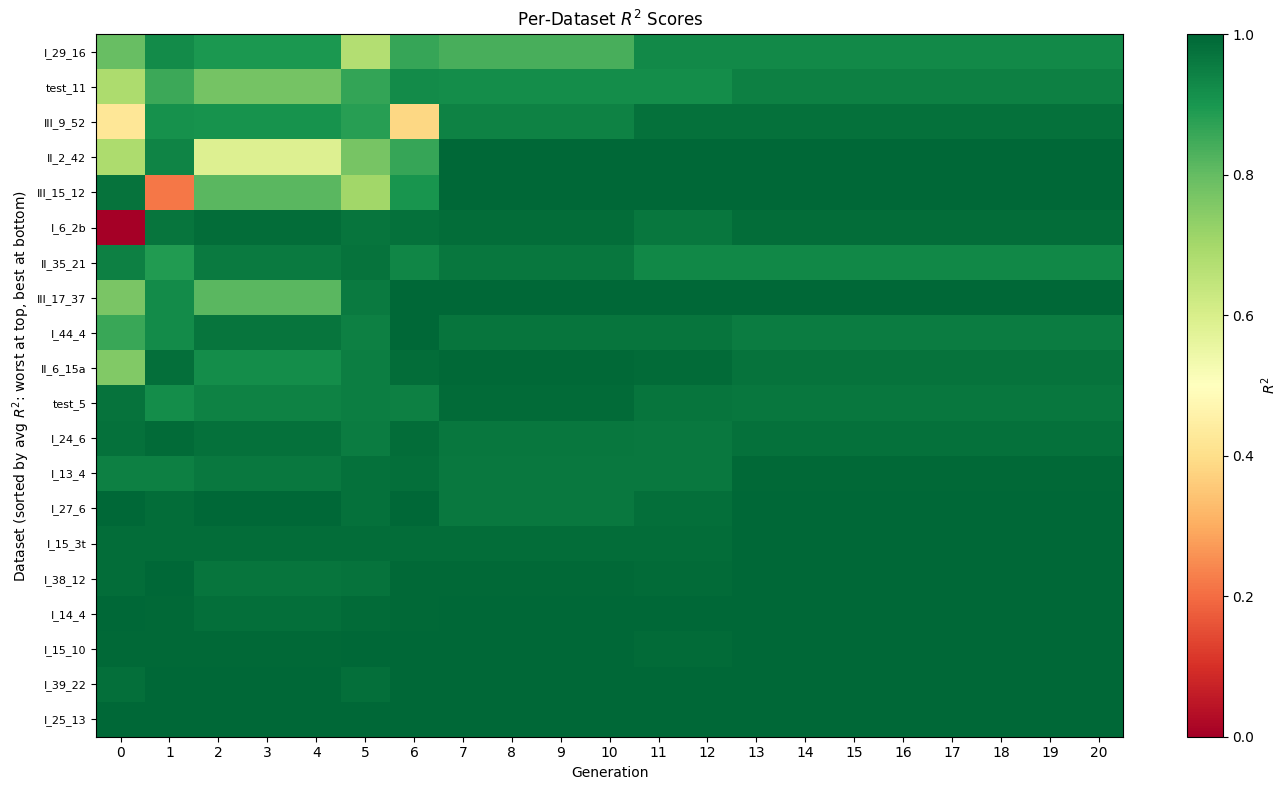

In [150]:
# Plot per-dataset R^2 heatmap
plot_per_dataset_r2(elite_bundles, dataset_names, log_scale=False)